In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.
We used a barnes weighting function, bilinear interpolation, and the
schlatter method to perform a univariate SOA. We varied the number
of observations being inlcuded for an analysis point to see any changes.

"""
__author__    = "Ethan Weisberger"
__contact__   = "ethan.weisberger@und.edu"

In [2]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import pandas as pd                #pandas
import scipy
from scipy import interpolate as scp
import math

In [3]:
### Read in observations ###
df=pd.read_csv("RAOBs_201903131200.txt", sep=',', names=['station', 'lat', 'lon', 'height', 'winddir', 'windsp'])

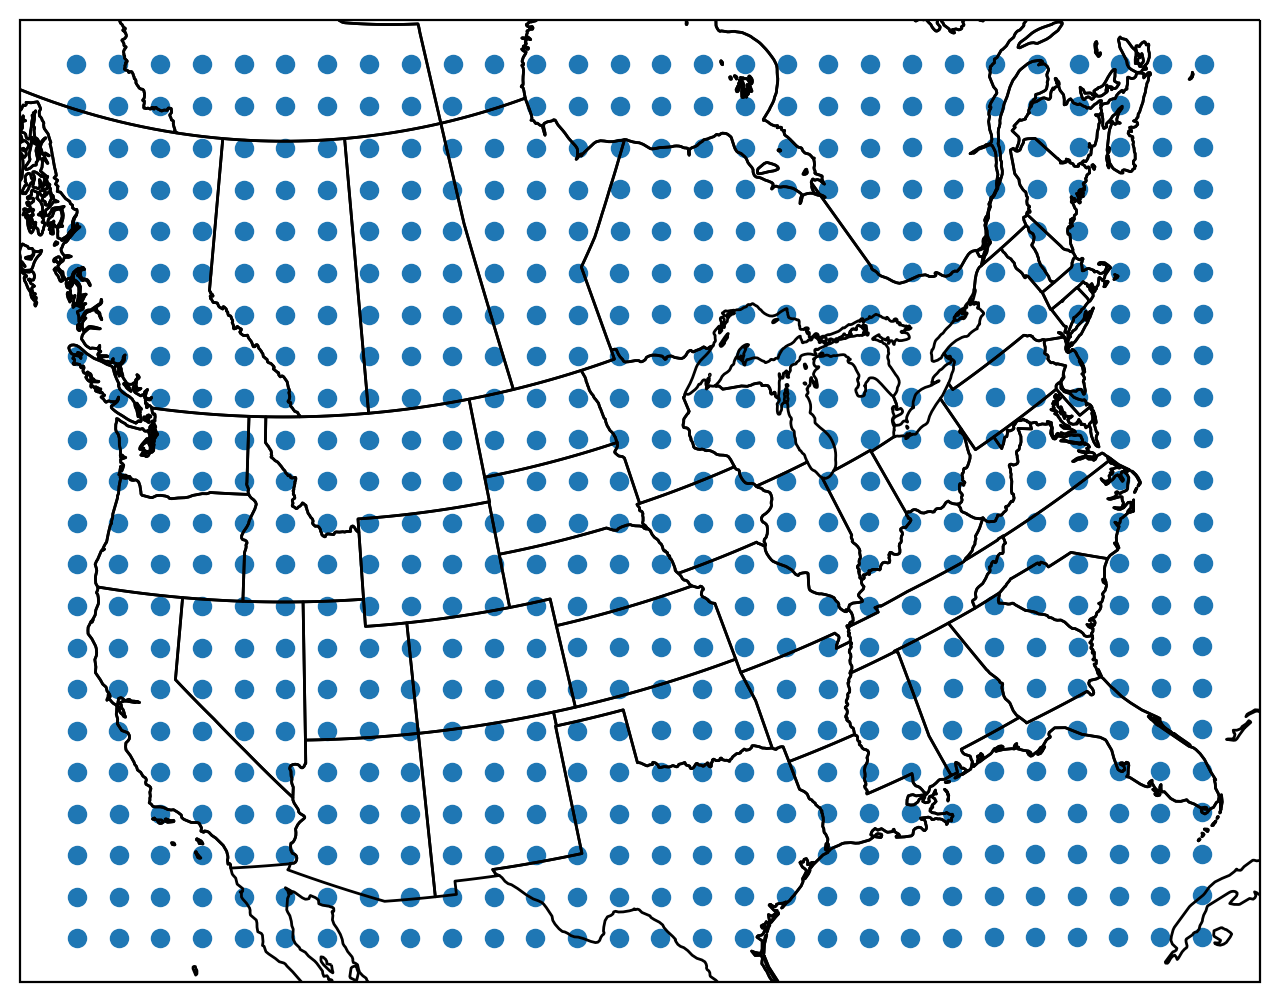

In [4]:
### Set up analysis map with a 22x28 rectangular grid of points ###

#Known Values
map_scale = 1/15000000
rho = 6371*1e5 #radius of Earth
lambda_o = -115 #standard lon
phi_not = 60 * (np.pi/180) #standard lat
phi_40 = 40 * (np.pi/180)
range_factor = 1.24


#Create 22x28 grid using correct spacing and start locations
x_s=18.9+np.arange(22)*1.27
y_s=-6.3+np.arange(28)*1.27
x,y = np.meshgrid(x_s,y_s)

#Calculate Image Scale
sigma = (1+np.sin(phi_not))/(1+np.sin(df['lat']*np.pi/180))
sigma_40 = (1+np.sin(phi_not))/(1+np.sin(phi_40))

#Calculate radius of any latitude circle
r=rho*sigma*np.cos(df['lat']*np.pi/180)*map_scale

map_new = range_factor/sigma_40
#Eq from lat/lon to Grid X/Y
y_lat = (180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x/map_scale)**2+(y/map_scale)**2)/(rho*(1+np.sin(phi_not))))))
#print(y_lat)
x_lon = np.arctan(y/x)*(180/np.pi)+lambda_o
#print(lon_y)
xx=r*np.cos(df.lon*(np.pi/180)-lambda_o*(np.pi/180)) #lambda is longitude
yy=r*np.sin(df.lon*(np.pi/180)-lambda_o*(np.pi/180)) #deviation from standard longitude
#print(xx)
xx=np.array(xx)
yy=np.array(yy)

#Plot analysis grid on map
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(x_lon,y_lat, transform=ccrs.PlateCarree())


In [5]:
# Define ROIs

R1 = 12.7775892 #cm


In [6]:
### Create function for Barnes Analysis ###
Kd = 10.8844524 #cm
def barnes(dik,Radius):
    if dik<=Radius:
        w_dik_R = math.exp((-(dik)**2)/Kd)
    else:
        w_dik_R = 0
    return w_dik_R

In [7]:
### Create function for bilinear interpolation ###

def bilinear(xval,yval,roi):
    rel_x = xval-np.floor(xval) #np.floor rounds down to nearest integer
    rel_y = yval-np.floor(yval)
    
    z1 = fb[int(np.floor(yval)), int(np.floor(xval)), roi]
    z2 = fb[int(np.ceil(yval)), int(np.floor(xval)), roi] #np.ceil rounds up to nearest integer
    z3 = fb[int(np.ceil(yval)), int(np.ceil(xval)), roi]
    z4 = fb[int(np.floor(yval)), int(np.ceil(xval)), roi]
    
    B = ((rel_x-1)*(rel_y-1)*z1)-((rel_x-0)*(rel_y-1)*z2)+((rel_x-0)*(rel_y-0)*z3)-((rel_x-1)*(rel_y-0)*z4)
    return B

<a list of 11 text.Text objects>

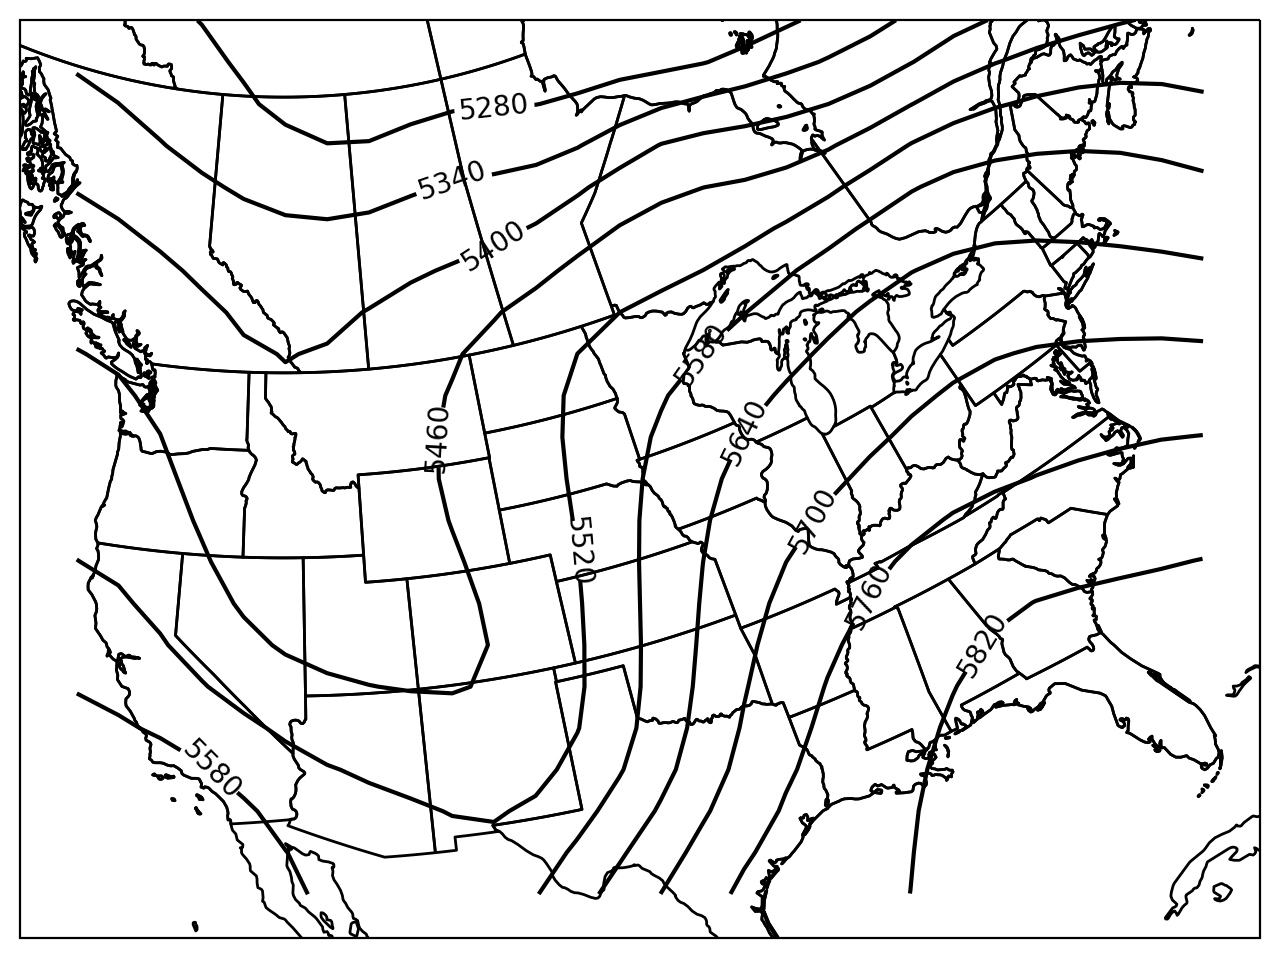

In [8]:
### Perform 500mb geopotential height analyses using a Barnes weighting Function###  (First analysis, Background)

fb= np.zeros((28,22,135))
fo_rk = np.array(df.height)

for j in range(len(x)): #28
    for k in range(len(x[0])):
        xa = x[j,k] - xx
        ya = y[j,k] - yy
        radius = np.sqrt((xa)**2 + (ya)**2)
        idx_array = np.where(radius<=R1)[0]
        weights=np.zeros(len(xa))
        for i in idx_array:
            w = barnes(radius[i],R1)
            weights[i]=w
        fb[j,k,0]= np.sum(weights*fo_rk)/np.sum(weights)
        
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,fb[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))

In [9]:
#calc some stuff for bilinear
obs_rel_x=(xx-18.9)/1.27
obs_rel_y=(yy+6.3)/1.27
bi1=np.zeros(len(xx))
#do bilinear interpolation to find the analysis values at observation locations
for i in range(len(obs_rel_x)):
    #check if observation is in grid or outside grid
    if(obs_rel_x[i]>=0) and (obs_rel_x[i]<21) and (obs_rel_y[i]>=0) and (obs_rel_y[i]<27):
        b=bilinear(obs_rel_x[i],obs_rel_y[i],0)
    else:
        xr=xx[i]-x
        yr=yy[i]-y
        radius=np.sqrt((xr**2)+(yr**2))
        idx_array=np.where(radius<=R1)
        weights=np.zeros(x.shape)
        for j in idx_array[0]:
            for k in idx_array[1]:
                w=barnes(radius[j,k], R1)
                weights[j,k]=w
        b=np.sum(weights*fb[:,:,0])/np.sum(weights)
    bi1[i]=b



C:\Users\ethan.weisberger\AppData\Local\Temp\ipykernel_4744\2870459210.py:20: RuntimeWarning: invalid value encountered in double_scalars
  b=np.sum(weights*fb[:,:,0])/np.sum(weights)


In [10]:
def schlatter(s):
    ps = 0.95*np.exp(-1.24*(s**2))
    ps[s<1e-3]=1
    return ps

In [11]:
N = [2,4,10]
an_grid_matrix = np.zeros((28,22,len(N)))

for n in range(len(N)):
    num = N[n]
    for i in range(len(x)):
        for j in range(len(x[i])):
            r = ((x[i,j]-xx)**2+(y[i,j]-yy)**2)**(1/2)
            radius_new = r*(0.15)
            sorted_index = np.argsort(radius_new)
            xobs = xx[sorted_index[:num]]
            yobs = yy[sorted_index[:num]]
            dist = radius_new[sorted_index[:num]]
            heights = fo_rk[sorted_index[:num]]
            bilinears = bi1[sorted_index[:num]]
            correlation_array = np.zeros((num,num))
            correlation_grid_obs = np.zeros((num,num))

            for k in range(len(xobs)):
                dik = ((xobs[k]-xobs)**2+(yobs[k]-yobs)**2)**(1/2)
                correlation_array[k] = schlatter(dik*0.15)
                
            correlation_grid_obs = np.matrix(schlatter(dist)).T
            weights = np.array(np.linalg.inv(correlation_array)*(correlation_grid_obs)).flatten()
            an_grid_matrix[i,j,n] = fb[i,j,0] + np.nansum(weights*(heights-bilinears))

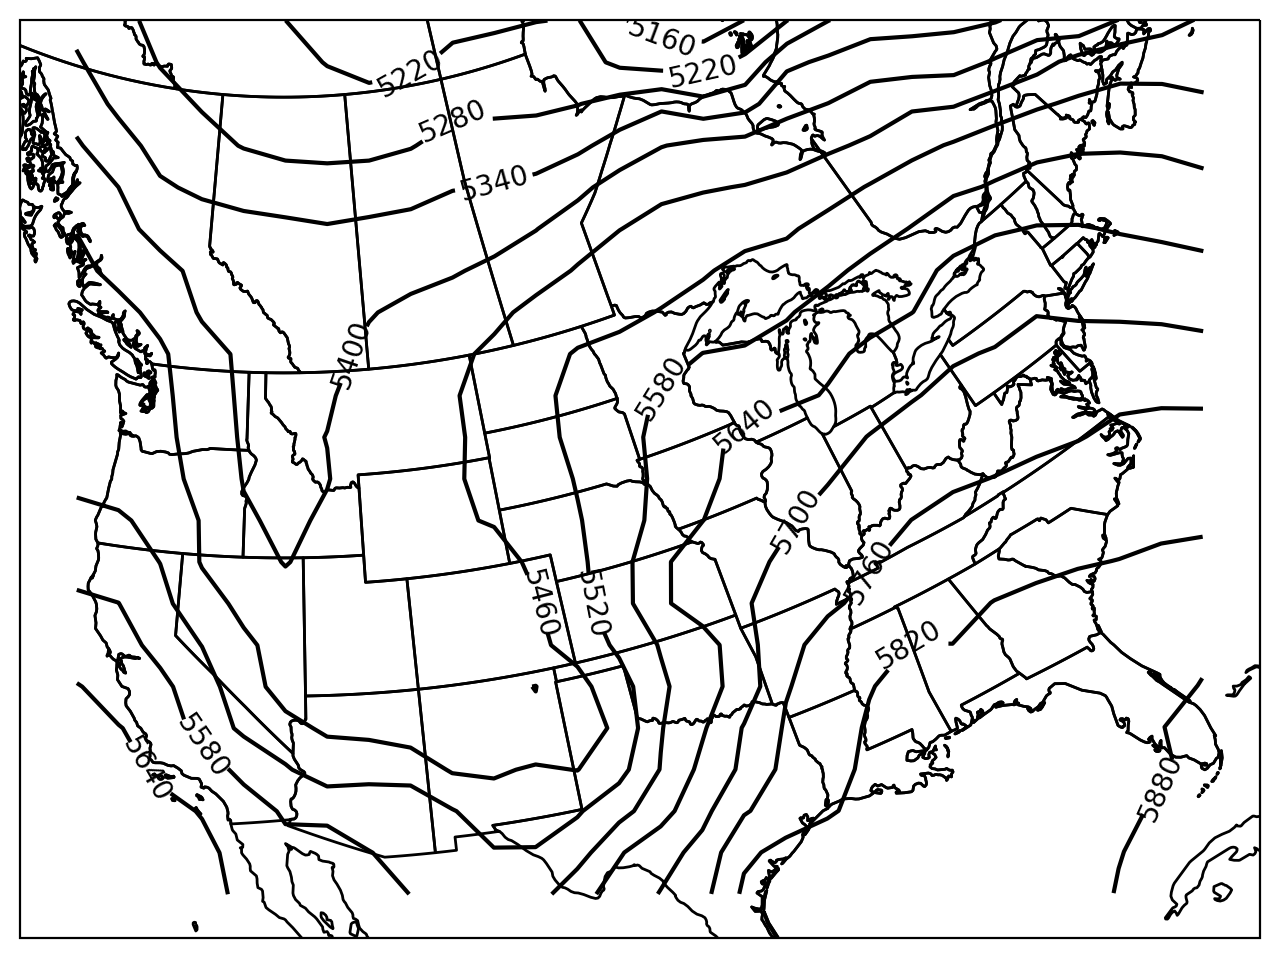

In [12]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,an_grid_matrix[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.savefig('an1.png')


an1 = open('analysis_1st.txt', 'w')
for row in an_grid_matrix[:,:,0]:
    np.savetxt(an1, row)
an1.close()

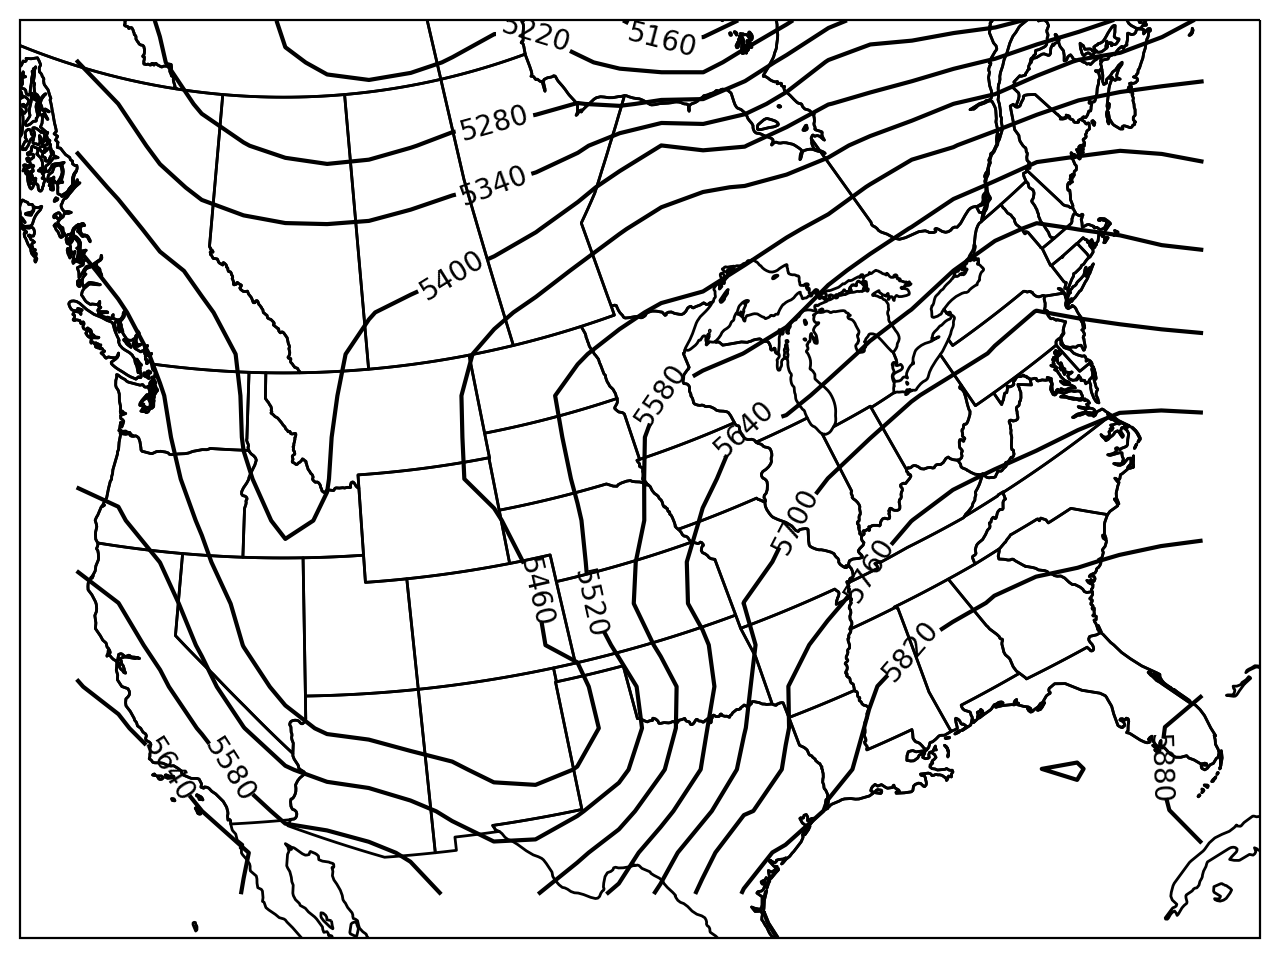

In [13]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,an_grid_matrix[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.savefig('an2.png')

an2 = open('analysis_2nd.txt', 'w')
for row in an_grid_matrix[:,:,1]:
    np.savetxt(an2, row)
an2.close()

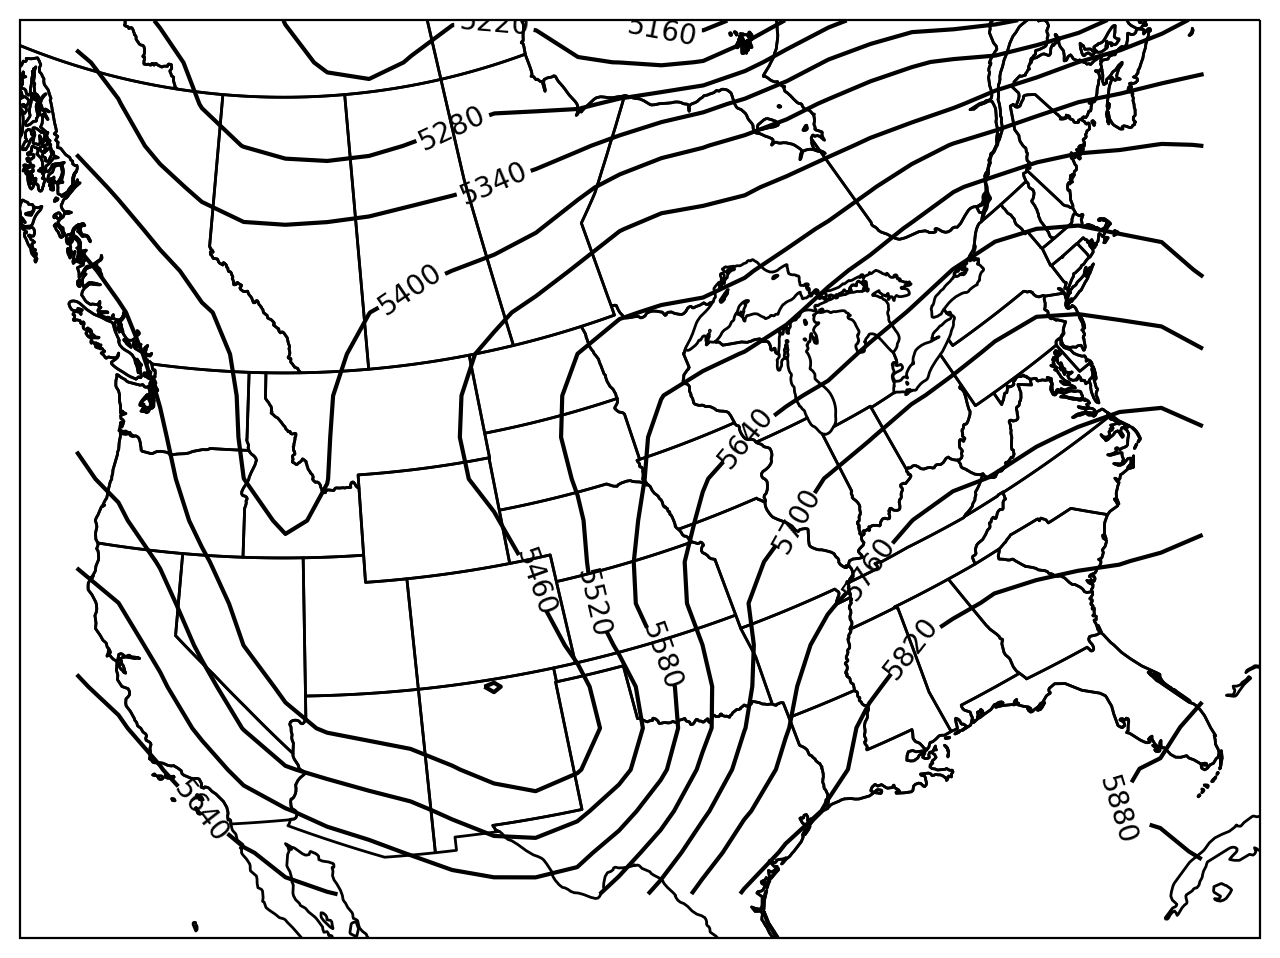

In [14]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,an_grid_matrix[:,:,2],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.savefig('an3.png')

# Store analysis in text file
an3 = open('analysis_3rd.txt', 'w')
for row in an_grid_matrix[:,:,2]:
    np.savetxt(an3, row)
an3.close()

In [15]:
# Analysis Increment Stuff
anal_in_N2 = an_grid_matrix[:,:,0] - fb[:,:,0]
anal_in_N4 = an_grid_matrix[:,:,1] - fb[:,:,0]
anal_in_N10 = an_grid_matrix[:,:,2] - fb[:,:,0]

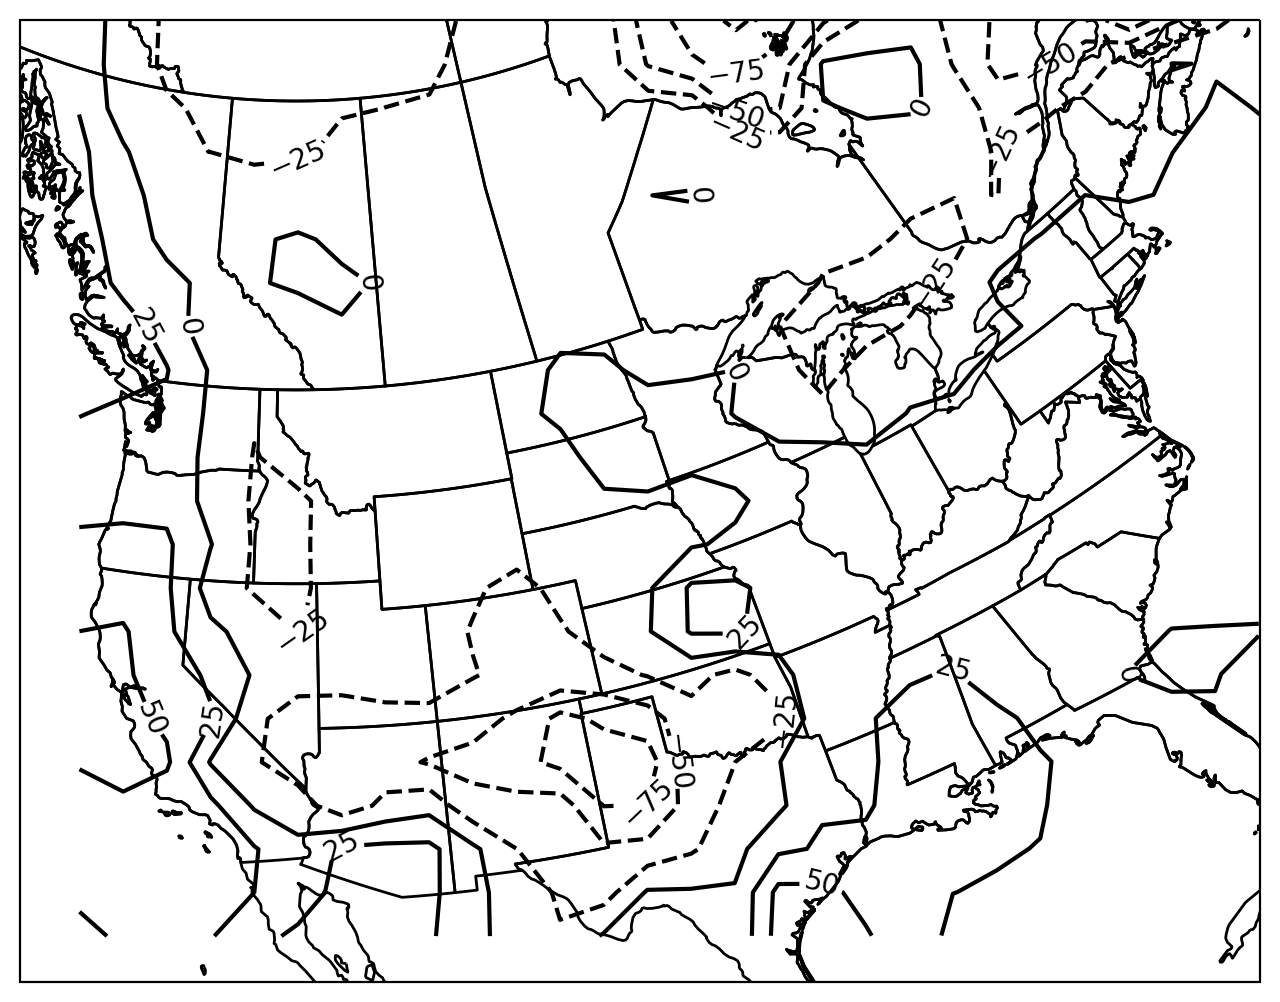

In [16]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,anal_in_N2[:,:],colors='k',levels=np.arange(-2000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-2000,8000,25))
plt.savefig('anal_inc_N2.png')

# Store analysis in text file
an1 = open('anal_inc_N2.txt', 'w')
for row in anal_in_N2[:,:]:
    np.savetxt(an1, row)
an1.close()

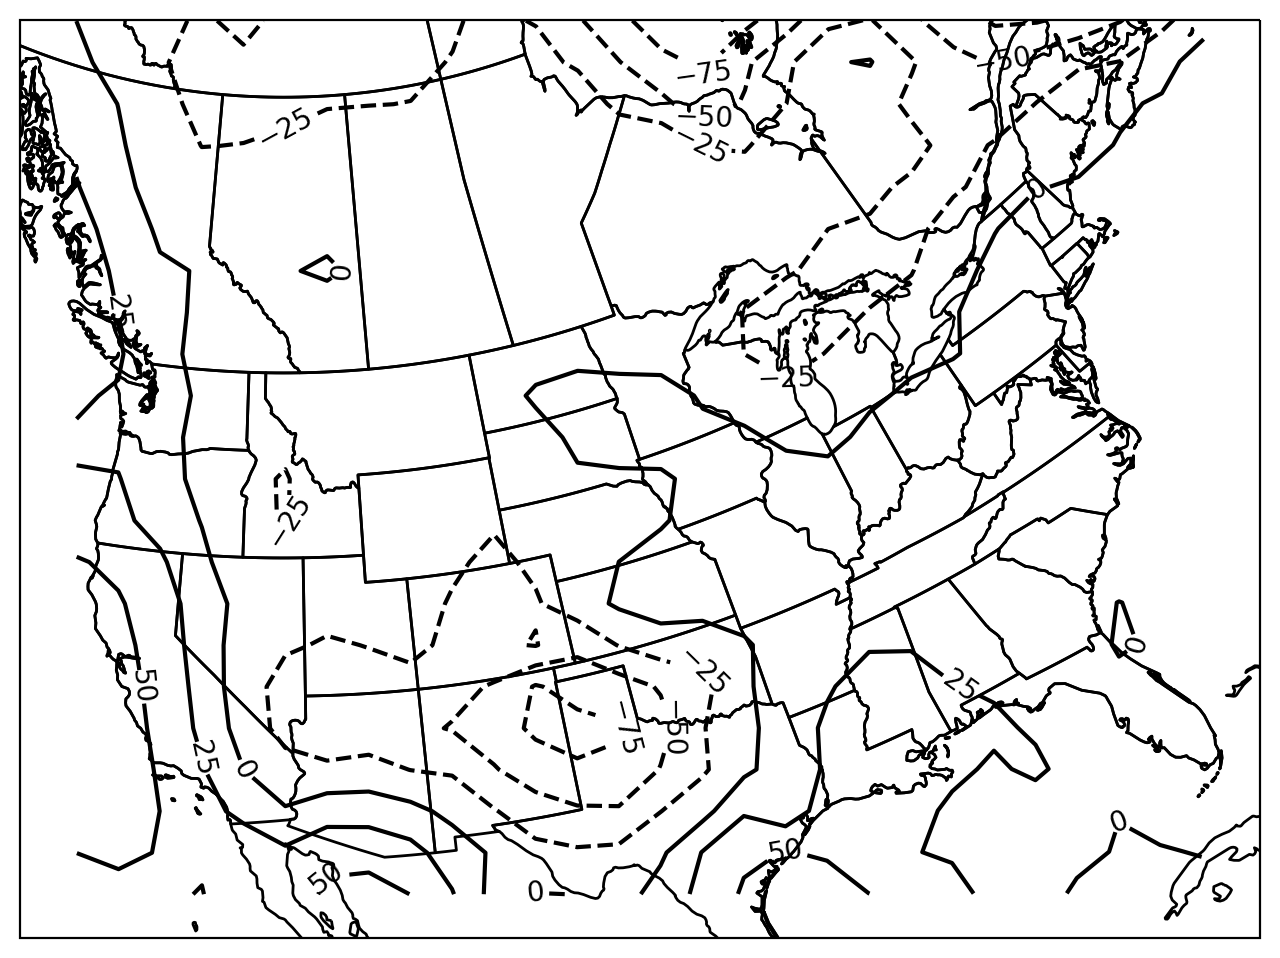

In [17]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,anal_in_N4[:,:],colors='k',levels=np.arange(-2000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-2000,8000,25))
plt.savefig('anal_inc_N4.png')

# Store analysis in text file
an2 = open('anal_inc_N4.txt', 'w')
for row in anal_in_N4[:,:]:
    np.savetxt(an2, row)
an2.close()

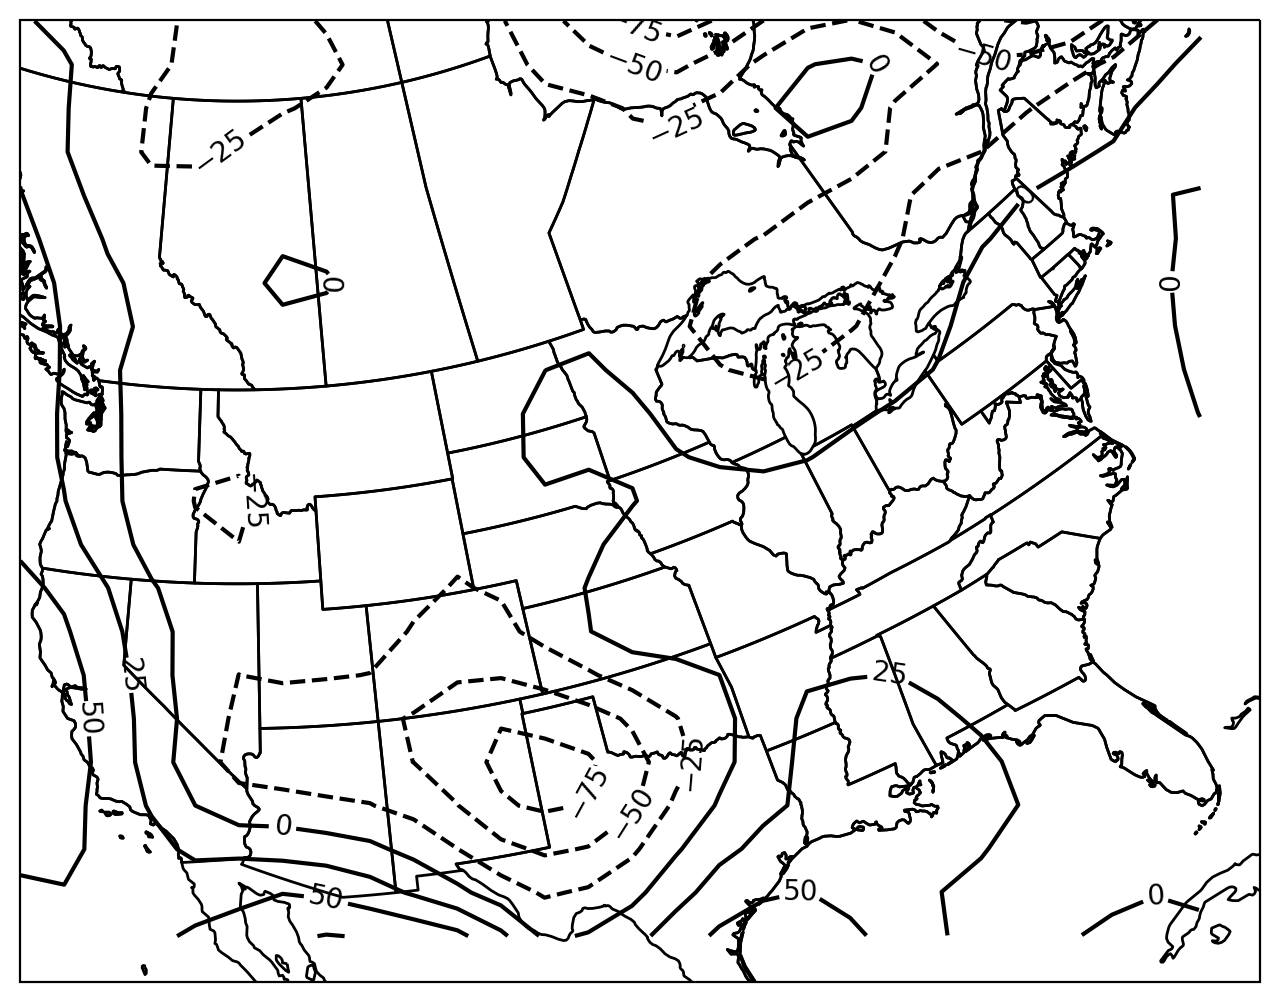

In [18]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

cs1 = ax1.contour(x_lon,y_lat,anal_in_N10[:,:],colors='k',levels=np.arange(-2000,8000,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-2000,8000,25))
plt.savefig('anal_inc_N10.png')

# Store analysis in text file
an3 = open('anal_inc_N10.txt', 'w')
for row in anal_in_N10[:,:]:
    np.savetxt(an3, row)
an3.close()

In [19]:
#Analysis Difference N2
#bilinear analysis 1
obs_rel_x=(xx-18.9)/1.27
obs_rel_y=(yy+6.3)/1.27
bi2=np.zeros(len(xx))
#do bilinear interpolation to find the analysis values at observation locations
for i in range(len(obs_rel_x)):
    #check if observation is in grid or outside grid
    if(obs_rel_x[i]>=0) and (obs_rel_x[i]<21) and (obs_rel_y[i]>=0) and (obs_rel_y[i]<27):
        b=bilinear(obs_rel_x[i],obs_rel_y[i],0)
    else:
        xr=xx[i]-x
        yr=yy[i]-y
        radius=np.sqrt((xr**2)+(yr**2))
        idx_array=np.where(radius<=R1)
        weights=np.zeros(x.shape)
        for j in idx_array[0]:
            for k in idx_array[1]:
                w=barnes(radius[j,k], R1)
                weights[j,k]=w
        b=np.sum(weights*an_grid_matrix[:,:,0])/np.sum(weights)
    bi2[i]=b
    
    
    
  

C:\Users\ethan.weisberger\AppData\Local\Temp\ipykernel_4744\649698352.py:21: RuntimeWarning: invalid value encountered in double_scalars
  b=np.sum(weights*an_grid_matrix[:,:,0])/np.sum(weights)


In [20]:
obs_rel_x=(xx-18.9)/1.27
obs_rel_y=(yy+6.3)/1.27
bi3=np.zeros(len(xx))
#do bilinear interpolation to find the analysis values at observation locations
for i in range(len(obs_rel_x)):
    #check if observation is in grid or outside grid
    if(obs_rel_x[i]>=0) and (obs_rel_x[i]<21) and (obs_rel_y[i]>=0) and (obs_rel_y[i]<27):
        b=bilinear(obs_rel_x[i],obs_rel_y[i],0)
    else:
        xr=xx[i]-x
        yr=yy[i]-y
        radius=np.sqrt((xr**2)+(yr**2))
        idx_array=np.where(radius<=R1)
        weights=np.zeros(x.shape)
        for j in idx_array[0]:
            for k in idx_array[1]:
                w=barnes(radius[j,k], R1)
                weights[j,k]=w
        b=np.sum(weights*an_grid_matrix[:,:,1])/np.sum(weights)
    bi3[i]=b

C:\Users\ethan.weisberger\AppData\Local\Temp\ipykernel_4744\1909261995.py:19: RuntimeWarning: invalid value encountered in double_scalars
  b=np.sum(weights*an_grid_matrix[:,:,1])/np.sum(weights)


In [21]:
obs_rel_x=(xx-18.9)/1.27
obs_rel_y=(yy+6.3)/1.27
bi4=np.zeros(len(xx))
#do bilinear interpolation to find the analysis values at observation locations
for i in range(len(obs_rel_x)):
    #check if observation is in grid or outside grid
    if(obs_rel_x[i]>=0) and (obs_rel_x[i]<21) and (obs_rel_y[i]>=0) and (obs_rel_y[i]<27):
        b=bilinear(obs_rel_x[i],obs_rel_y[i],0)
    else:
        xr=xx[i]-x
        yr=yy[i]-y
        radius=np.sqrt((xr**2)+(yr**2))
        idx_array=np.where(radius<=R1)
        weights=np.zeros(x.shape)
        for j in idx_array[0]:
            for k in idx_array[1]:
                w=barnes(radius[j,k], R1)
                weights[j,k]=w
        b=np.sum(weights*an_grid_matrix[:,:,2])/np.sum(weights)
    bi3[i]=b

C:\Users\ethan.weisberger\AppData\Local\Temp\ipykernel_4744\1958812315.py:19: RuntimeWarning: invalid value encountered in double_scalars
  b=np.sum(weights*an_grid_matrix[:,:,2])/np.sum(weights)


In [22]:
obs = np.array(df['height'])
diff1 = bi1[i] - obs
diff2 = bi2[i] - obs
diff3 = bi3[i] - obs

dif1 = open('dif1.txt', 'w')
np.savetxt(dif1, diff1)
dif1.close()

dif2 = open('dif2.txt', 'w')
np.savetxt(dif2, diff2)
dif2.close()

dif3 = open('dif3.txt', 'w')
np.savetxt(dif3, diff3)
dif3.close()

In [23]:
diff1 = (obs - bi1)**2
diff1 = diff1[~np.isnan(diff1)]
rmse1 = np.sqrt(np.sum(diff1)/len(diff1))
print(rmse1,'m')

diff2 = (obs - bi2)**2
diff2 = diff2[~np.isnan(diff2)]
rmse2 = np.sqrt(np.sum(diff2)/len(diff2))
print(rmse2,'m')

diff3 = (obs - bi3)**2
diff3 = diff3[~np.isnan(diff3)]
rmse3 = np.sqrt(np.sum(diff3)/len(diff3))
print(rmse3,'m')


# Store RMSE in text file
rmse1file = open('rmse_1st.txt', 'w')
rmse1in = str(rmse1)
rmse1file.write(rmse1in)
rmse1file.close()

# Store RMSE in text file
rmse2file = open('rmse_2nd.txt', 'w')
rmse2in = str(rmse2)
rmse2file.write(rmse2in)
rmse2file.close()

# Store RMSE in text file
rmse3file = open('rmse_3rd.txt', 'w')
rmse3in = str(rmse3)
rmse3file.write(rmse3in)
rmse3file.close()

60.51971093707089 m
55.80933937402148 m
54.612442691983574 m


In [24]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.

    In all thee analyses there is a trough over over the western US while there is ridging over the eastern US.
    The general structure of these featurs is the same between the analyses, but further analyses become smoother.


2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    
    The first analysis is much choppier than the second or third. This especially be seen with the height
    contours over the central US. 
    
    This is because there are more observations taken into account at each analysis location as I
    went along (analysis 1 has 2 observation per analysis location, while analysis 3 has 10).

    

3 - What happens as you increase the number of points considered for the analysis?  Is this 
    desirable?  Why or why not?
    
    The contours get smoother the more observations you include in the analysis values, however the
    large scale features are the same in all the analyses. This would suggest that there don't need to be
    many observtions considered for a roughly accurate analysis, however more observations make a smoother 
    analysis while keeping the same features, creating a more pleasurable synoptic map viewing experience.
    
'''

"\n1 - Describe the general features that you see in your contoured analyses.\n\n    In all thee analyses there is a trough over over the western US while there is ridging over the eastern US.\n    The general structure of these featurs is the same between the analyses, but further analyses become smoother.\n\n\n2 - Describe the differences that you see in your contoured analyses.  \n    Does one analysis seem to be smoother than the other?  If so, what would cause this?\n    \n    The first analysis is much choppier than the second or third. This especially be seen with the height\n    contours over the central US. \n    \n    This is because there are more observations taken into account at each analysis location as I\n    went along (analysis 1 has 2 observation per analysis location, while analysis 3 has 10).\n\n    \n\n3 - What happens as you increase the number of points considered for the analysis?  Is this \n    desirable?  Why or why not?\n    \n    The contours get smoother t